In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cbx as cbx
from cbx.dynamics import CBO, MCBO, regCBO1, regCBO2, regCBO3, ProjectionCBO
import cbx.mirrormap as mirrormap
import cbx.constraints as constraints
import cbx.utils as cbx_utils

from cbx.objectives import Rastrigin, Ackley, TV_objective, L2Norm
import cbx.utils.termination as term
from cbx.scheduler import effective_sample_size, multiply, scheduler
from cbx.utils.objective_handling import cbx_objective_fh
from cbx.plotting import PlotDynamic, PlotDynamicHistory, PlotErrorDynamic, PlotErrorHistory
import matplotlib.pyplot as plt
from IPython import display
import itertools
plt.rc('image', cmap = 'pastel1')

In [26]:
np.random.seed(420)
conf = {'alpha': 50.0,
        'dt': 0.01,
        'sigma': 5, 
        'lamda': 1.0,
        'batch_args':{
        'batch_size':200,
        'batch_partial': False},
        'd': 4,
        'max_it': 1000,
        'N': 100,
        'M': 3,
        'track_args': {'names':
                       ['update_norm',
                        'energy','x',
                        'consensus',
                        'drift', 
                        'error']}}

In [27]:
x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2, x_max = 2)
minima1 = (np.array([1/np.sqrt(2), -1/np.sqrt(2)])).tolist()
minima2 = (np.ones((1, 20))*20**(-1/2)).tolist()
minima3 = np.zeros(conf['d']).tolist()

fA = Ackley( minima = minima3 )
fR = Rastrigin()
V = L2Norm(minima = minima3)

global_min = minima3
sched = effective_sample_size(maximum=1e12)

# vanilla CBO
dyn_CBO = CBO(fA, x=x, noise='anisotropic', f_dim='3D',
          **conf)

# existing constrained CBO methods
dyn_reg1 = regCBO1(fA, x=x, noise='anisotropic', f_dim='3D', eps_g = 0.01, 
          **conf)
dyn_reg2 = regCBO2(fA, x=x, noise='anisotropic', f_dim='3D', eps_g = 0.01, 
          **conf)
dyn_reg3 = regCBO3(fA, x=x, noise='anisotropic', f_dim='3D', eps_g = 0.01, 
          **conf)
dyn_proj = ProjectionCBO(fA, x=x, noise='anisotropic', f_dim='3D',
          **conf)

# mirror CBO with different mirror maps
dyn_MPB = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.ProjectionBall(),
          **conf)
dyn_ML2 = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.L2(),
          **conf)
dyn_MLB = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.LogBarrier(),
          **conf)
dyn_EN = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.ElasticNet(),
          **conf)
dyn_entropy = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.Entropy(),
          **conf)

# mirror CBO with indicator function as mirror map
C = np.array(list(itertools.product([-1, 1], repeat= conf['d'])))
dyn_indicator = MCBO(V, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.Indicator(C),
          **conf)

dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN, dyn_entropy, dyn_indicator]
name_list = ['CBO', 'regularized_CBO_1', 'regularized_CBO_2', 'regularized_CBO_3', 'Projecion CBO', 'Mirror CBO - PB', ...
             , 'Mirror CBO - LB', 'Mirror CBO - EN', 'Mirror CBO - Ind']

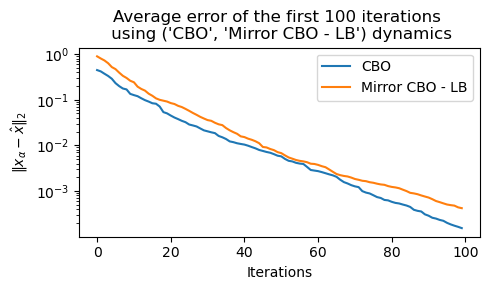

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5, 3))
Nsimul = 10
error_list = np.zeros((Nsimul, len(dyn_list), conf['max_it']))
for n in range(0, Nsimul):
    x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2., x_max = 2.)
    dyn_CBO = CBO(fA, x=x, noise='anisotropic', f_dim='3D',
          **conf)
    dyn_EN = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.ElasticNet(),
          **conf)
    dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN, dyn_entropy]
    
    for j in range(0, len(dyn_list), 7):
        dyn = dyn_list[j]
        k = 0
        while not dyn.terminate():
            dyn.step(global_min)
            sched.update(dyn)
            # e = (dyn.history['error'])[k]
            # error_list[n, j, k] = np.average(e) # average over the N particles / M simulations
            error_list[n, j, k] = np.average(dyn.error)
            # print(e[k].shape)
            k += 1
        m = dyn.history['consensus']
        test = abs(m[-1] - global_min) < 0.001

for j in range(0, len(dyn_list), 7): 
    ax.semilogy(range(conf['max_it']), np.mean(error_list[:, j, range(conf['max_it'])], axis = 0), label = name_list[j])
    j_title = f"Average error of the first {conf['max_it']} iterations \n using {name_list[0], name_list[7]} dynamics"
    ax.set_title(j_title)
    ax.set_xlabel('Iterations')
    ax.set_ylabel(r'$\|x_{\alpha} - \hat{x}\|_2$') 
    
plt.tight_layout()
ax.legend()

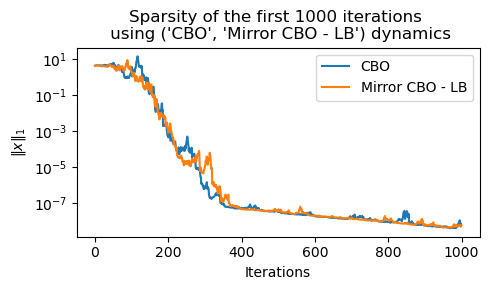

In [28]:
# when global_min = minima3 -- all zeors
fig, ax = plt.subplots(1,1, figsize=(5, 3))
Nsimul = 50
s = np.zeros((Nsimul, len(dyn_list), conf['max_it']))

for n in range(0, Nsimul):
    x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2., x_max = 2.)
    dyn_CBO = CBO(fA, x=x, noise='anisotropic', f_dim='3D',
          **conf)
    dyn_EN = MCBO(fA, x=x, noise='anisotropic', f_dim='3D', MirrorFct = mirrormap.ElasticNet(),
          **conf)
    dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN, dyn_entropy]
    for j in range(0, len(dyn_list), 7):
        dyn = dyn_list[j]
        k = 0
        while not dyn.terminate():
            dyn.step(global_min)
            sched.update(dyn)
            s[n, j, k] = np.average(dyn.sparsity, axis = 0)
            k += 1

for j in range(0, len(dyn_list), 7):
    ax.semilogy(range(conf['max_it']), np.mean(s[:, j, range(conf['max_it'])], axis = 0), label = name_list[j])
    j_title = f"Sparsity of the first {conf['max_it']} iterations \n using {name_list[0], name_list[7]} dynamics"
    ax.set_title(j_title)
    ax.set_xlabel('Iterations')
    ax.set_ylabel(r'$\|x\|_1$') 
    
plt.tight_layout()
ax.legend()

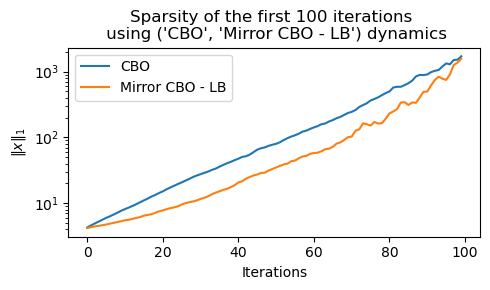

In [8]:
# when global_min = minima1 -- (1/sqrt{2}, -1/sqrt{2}) 
fig, ax = plt.subplots(1,1, figsize=(5, 3))
Nsimul = 50
s = np.zeros((Nsimul, len(dyn_list), conf['max_it']))

for n in range(0, Nsimul):
    x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2., x_max = 2.)
    dyn_CBO = CBO(fA, x=x, noise='isotropic', f_dim='3D',
          **conf)
    dyn_EN = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.ElasticNet(),
          **conf)
    dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN, dyn_entropy]
    for j in range(0, len(dyn_list), 7):
        dyn = dyn_list[j]
        k = 0
        while not dyn.terminate():
            dyn.step(global_min)
            sched.update(dyn)
            s[n, j, k] = np.average(dyn.sparsity, axis = 0)
            k += 1

for j in range(0, len(dyn_list), 7):
    ax.semilogy(range(conf['max_it']), np.mean(s[:, j, range(conf['max_it'])], axis = 0), label = name_list[j])
    j_title = f"Sparsity of the first {conf['max_it']} iterations \n using {name_list[0], name_list[7]} dynamics"
    ax.set_title(j_title)
    ax.set_xlabel('Iterations')
    ax.set_ylabel(r'$\|x\|_1$') 
    
plt.tight_layout()
ax.legend()

In [71]:
np.random.seed(420)
conf = {'alpha': 40.0,
        'dt': 0.1,
        'sigma': 1.,#8,#5.1,#8.0,
        'lamda': 1.0,
        'batch_args':{
        'batch_size':200,
        'batch_partial': False},
        'd': 2,
        'max_it': 200,
        'N': 500,
        'M': 3,
        'track_args': {'names':
                       ['update_norm',
                        'energy','x',
                        'consensus',
                        'drift', 
                        'error']}}

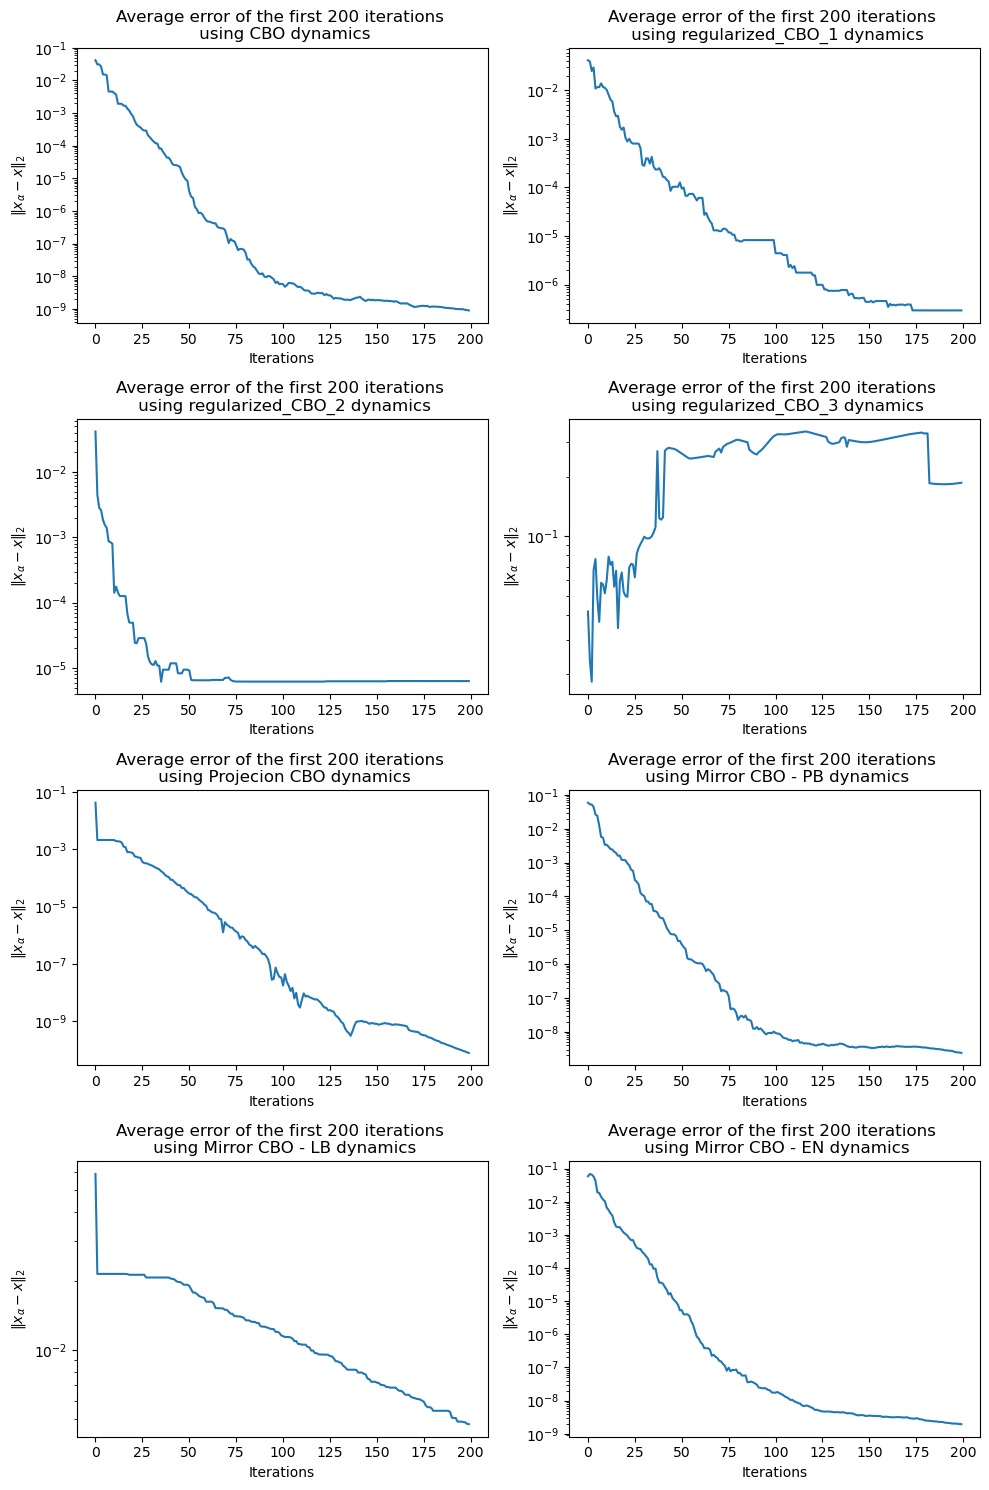

In [73]:
x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2., x_max = 2.)
# minima1 = (np.array([1/np.sqrt(2), -1/np.sqrt(2)])).tolist()
minima1 = (np.array([1/np.sqrt(2), -1/np.sqrt(2)])).tolist()
minima2 = (np.ones((1, 20))*20**(-1/2)).tolist()
minima3 = (np.array([0, 0])).tolist()
minima4 = np.zeros(conf['d']).tolist()
global_min = minima1
fA = Ackley( minima = minima1 )
fR = Rastrigin()

name_list = ['CBO', 'regularized_CBO_1', 'regularized_CBO_2', 'regularized_CBO_3', 'Projecion CBO', 'Mirror CBO - PB', 'Mirror CBO - LB', 'Mirror CBO - EN']
sched = effective_sample_size(maximum=1e12)

# fig, ax = plt.subplots(8,1, figsize=(15,20))
fig, ax = plt.subplots(4,2, figsize=(10, 15))

x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2., x_max = 2.)
# vanilla CBO
dyn_CBO = CBO(fA, x=x, noise='isotropic', f_dim='3D',
          **conf)

# existing constrained CBO methods
dyn_reg1 = regCBO1(fA, x=x, noise='isotropic', f_dim='3D', eps_g = 0.01, 
          **conf)
dyn_reg2 = regCBO2(fA, x=x, noise='isotropic', f_dim='3D', eps_g = 0.01, 
          **conf)
dyn_reg3 = regCBO3(fA, x=x, noise='isotropic', f_dim='3D', eps_g = 0.01, 
          **conf)
dyn_proj = ProjectionCBO(fA, x=x, noise='isotropic', f_dim='3D',
          **conf)

# mirror CBO with different mirror maps
dyn_MPB = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.ProjectionBall(),
          **conf)
dyn_ML2 = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.L2(),
          **conf)
dyn_MLB = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.LogBarrier(),
          **conf)
dyn_EN = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.ElasticNet(),
          **conf)
dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN]
error_list = np.zeros((len(dyn_list), conf['max_it']))
e = [];
score = np.zeros((len(dyn_list)))
rate = np.zeros(len(dyn_list))

for j in range(len(dyn_list)):
    dyn = dyn_list[j]
    k = 0
    while not dyn.terminate():
        dyn.step(global_min)
        sched.update(dyn)
        e = (dyn.history['error'])[k]
        error_list[j, k] = np.average(e) # average over the M batches
        # print(e[k].shape)
        k += 1
    m = dyn.history['consensus']
    # test = abs(m[-1] - global_min) < 0.001
#     # print(test.shape)
#     if (np.sum(test) == conf['M']*conf['d']):
#         score[:, j] = score[:, j] + 1                    
# score   

for j in range(len(dyn_list)): #range(1):
    ax[j//2, j%2].clear()    
    ax[j//2, j%2].semilogy(range(conf['max_it']),  error_list[j, range(conf['max_it'])], label = name_list[j]) 
    j_title = f"Average error of the first {conf['max_it']} iterations \n using {name_list[j]} dynamics"
    ax[j//2, j%2].set_title(j_title)
    # ax[j//2, j%2].set_ylim([10**-11, 10**-1])
    ax[j//2, j%2].set_xlabel('Iterations')
    ax[j//2, j%2].set_ylabel(r'$\|x_{\alpha} - \hat{x}\|_2$') 
plt.tight_layout()

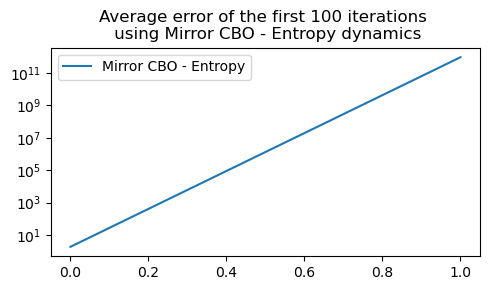

In [79]:
# from cbx.mirrormap import Entropy
x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=0.1, x_max = 4.)
minima1 = (np.array([1/np.sqrt(2), -1/np.sqrt(2)])).tolist()
minima2 = (np.ones((1, 20))*20**(-1/2)).tolist()
minima3 = (np.array([0, 0])).tolist()
minima4 = np.zeros(conf['d']).tolist()

fA = Ackley( minima = minima1 )
fR = Rastrigin()
global_min = minima1
sched = effective_sample_size(maximum=1e12)

error_list = np.zeros((1, conf['max_it']))
fig, ax = plt.subplots(1,1, figsize=(5, 3))

dyn_entropy = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.Entropy(),
          **conf)
dyn = dyn_entropy
k = 0
while not dyn.terminate():
    dyn.step(global_min)
    sched.update(dyn)
    e = (dyn.history['error'])[k]
    error_list[0, k] = np.average(e) # average over the N particles / M simulations
    # print(e[k].shape)
    k += 1

ax.semilogy(range(conf['max_it']), error_list[0, range(conf['max_it'])], label = 'Mirror CBO - Entropy')
j_title = f"Average error of the first 100 iterations \n using {'Mirror CBO - Entropy'} dynamics"
ax.set_title(j_title)
# ax.set_ylim([10**-11, 10**-1])
# ax.set_yticks(
ax.legend()
plt.tight_layout()

[1. 0. 0. 0. 0. 0. 0. 1.]


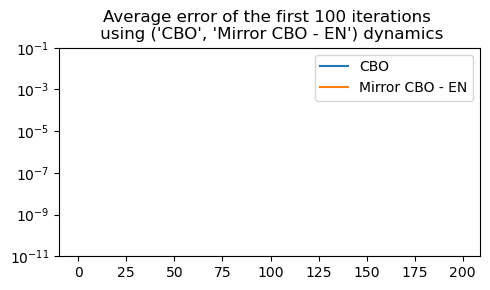

In [52]:
N_simul = 1; global_min = minima1
dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN]
error_list = np.zeros((N_simul, len(dyn_list), conf['max_it']))
name_list = ['CBO', 'regularized_CBO_1', 'regularized_CBO_2', 'regularized_CBO_3', 'Projecion CBO', 'Mirror CBO - PB', 'Mirror CBO - LB', 'Mirror CBO - EN']
sched = effective_sample_size(maximum=1e12)
e = [];
score = np.zeros((N_simul, len(dyn_list)))
rate = np.zeros(len(dyn_list))

# fig, ax = plt.subplots(8,1, figsize=(15,20))
fig, ax = plt.subplots(1,1, figsize=(5, 3))

for i in range(N_simul):
    x = cbx.utils.init_particles(shape=(conf['M'], conf['N'], conf['d']), x_min=-2., x_max = 2.)
    # vanilla CBO
    dyn_CBO = CBO(fA, x=x, noise='isotropic', f_dim='3D',
              **conf)
    
    # existing constrained CBO methods
    dyn_reg1 = regCBO1(fA, x=x, noise='isotropic', f_dim='3D', eps_g = 0.01, 
              **conf)
    dyn_reg2 = regCBO2(fA, x=x, noise='isotropic', f_dim='3D', eps_g = 0.01, 
              **conf)
    dyn_reg3 = regCBO3(fA, x=x, noise='isotropic', f_dim='3D', eps_g = 0.01, 
              **conf)
    dyn_proj = ProjectionCBO(fA, x=x, noise='isotropic', f_dim='3D',
              **conf)
    
    # mirror CBO with different mirror maps
    dyn_MPB = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.ProjectionBall(),
              **conf)
    dyn_ML2 = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.L2(),
              **conf)
    dyn_MLB = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.LogBarrier(),
              **conf)
    dyn_EN = MCBO(fA, x=x, noise='isotropic', f_dim='3D', MirrorFct = mirrormap.ElasticNet(),
              **conf)
    dyn_list = [dyn_CBO, dyn_reg1, dyn_reg2, dyn_reg3, dyn_proj, dyn_MPB, dyn_MLB, dyn_EN]
    for j in range(0, len(dyn_list), 7):
        dyn = dyn_list[j]
        k = 0
        while not dyn.terminate():
            dyn.step(global_min)
            sched.update(dyn)
            e = (dyn.history['error'])[0]
            error_list[i, j, k] = np.average(e) # average over the N particles / M simulations
            # print(e[k].shape)
            k += 1
        m = dyn.history['consensus']
        test = abs(m[-1] - global_min) < 0.001
        # print(test.shape)
        if (np.sum(test) == conf['M']*conf['d']):
            score[i, j] = score[i, j] + 1     
                
rate = np.sum(score, axis = 0)    

for i in range(N_simul):
    for j in range(0, len(dyn_list), 7):
        # ax[j//2, j%2].clear()    
        ax.semilogy(range(conf['max_it']), np.average(error_list[:, j, range(conf['max_it'])], axis = 0), label = name_list[j]) # can change to the average of the error of M batches
        j_title = f"Average error of the first {conf['max_it']} iterations \n using {name_list[0], name_list[7]} dynamics"
        ax.set_title(j_title)
        ax.set_ylim([10**-11, 10**-1])
        
        # ax.set_yticks(
ax.legend()
plt.tight_layout()
print(rate)

In [1]:
plotter = PlotDynamic(dyn, ax=ax[0],
                       objective_args={'x_min':-3, 'x_max':3},
                       plot_consensus=True,
                       plot_drift=True)
plotter.init_plot()
while not dyn.terminate():
    dyn.step(global_min)
    sched.update(dyn)
    # update energy plot
    ax[1].clear()
    ax[1].plot([e[0] for e in dyn.history['energy'][-30:]])
    ax[1].set_title('Energy of the last 30 iterations')

    ax[0].set_title('Iteration: ' + str(dyn.it))
    plotter.update(wait=0.2)
    display.display(fig)
    display.clear_output(wait=True)

NameError: name 'PlotDynamic' is not defined